# Imports

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

# Load data

In [29]:
from tqdm import tqdm
import os
import os.path as path
import requests
import zipfile

url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
root = path.join(".", "data")
zname = url.split("/")[-1]
fpath = zname.rsplit(".", 1)[0]

if not path.exists(path.join(root, zname)):
    with open(path.join(root, zname), "wb") as handle:
        response = requests.get(url, stream=True)
        for data in tqdm(response.iter_content()):
            handle.write(data)


if not path.exists(path.join(root, fpath)):
    with zipfile.ZipFile(path.join(root, zname), "r") as zfile:
        zfile.extractall(path.join(root, fpath))

In [120]:
import urllib
import sys
import os.path as path

def get_url_resource(url, root, fname=None):
    # TODO add function to make the download check file integrety / file existence
    length = 70
    fname = path.join(root,url.split('/')[-1] if fname==None else fname)
    if path.exists(fname):
        return
    
    response = urllib.request.urlopen(url)
    meta = response.info()
    
    fsize = int(meta["Content-Length"])
    print("Downloading: %s Bytes: %s" % (fname, fsize))
    fsize_dl = 0
    bsize = 8192
    
    with open(fname, "wb") as f:
        while True:
            buffer = response.read(bsize)
            if not buffer:
                break

            fsize_dl += len(buffer)
            f.write(buffer)
            status = "\r%10d  [%3.2f%%]" % (fsize_dl, fsize_dl * 100. / fsize)
            ratio = fsize_dl / fsize
            status += "|" + "#" * int(ratio*length) + " " * (length - int(ratio*length)) + "|"
            sys.stdout.write(status)
            
get_url_resource(url, root)

if not path.exists(path.join(root, fpath)):
    with zipfile.ZipFile(path.join(root, zname), "r") as zfile:
        zfile.extractall(path.join(root, fpath))

# Load Data and analyse

In [96]:
initial_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

train_set = datasets.ImageFolder(root="./data/hymenoptera_data/hymenoptera_data/train/",
                                transform=initial_transforms)

In [97]:
loader = DataLoader(
    train_set,
    batch_size=10,
    num_workers=1,
    shuffle=False
)

mean = 0.
std = 0.
nb_samples = 0.
for data in loader:
    inputs, labels = data
    
    batch_samples = inputs.size(0)
    inputs = inputs.view(batch_samples, inputs.size(1), -1)
    mean += inputs.mean(2).sum(0)
    std += inputs.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

# Make transformations

In [102]:
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = "data/hymenoptera_data/hymenoptera_data/"

image_datasets = {i: datasets.ImageFolder(os.path.join(data_dir, i), transform=data_transforms[i])
                  for i in ["train", "val"]}

dataloaders = {i: DataLoader(image_datasets[i], batch_size=4, shuffle=True, num_workers=4)
               for i in ["train", "val"]}

dataset_sizes = {i: len(image_datasets[i]) for i in ["train", "val"]}
class_names= image_datasets["train"].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Visualise data

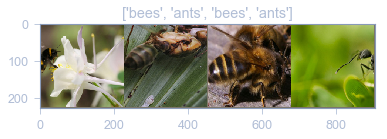

In [103]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Define more functions

In [104]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [105]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Fine tuning

In [118]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train and Eval

In [119]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6638 Acc: 0.6434
val Loss: 0.3806 Acc: 0.8366

Epoch 1/24
----------
train Loss: 0.5219 Acc: 0.7746
val Loss: 0.2431 Acc: 0.9150

Epoch 2/24
----------
train Loss: 0.4885 Acc: 0.8033
val Loss: 0.2266 Acc: 0.9085

Epoch 3/24
----------
train Loss: 0.5986 Acc: 0.7664
val Loss: 0.4720 Acc: 0.8693

Epoch 4/24
----------
train Loss: 0.5228 Acc: 0.7828
val Loss: 0.3169 Acc: 0.8627

Epoch 5/24
----------
train Loss: 0.4812 Acc: 0.8484
val Loss: 0.6624 Acc: 0.8497

Epoch 6/24
----------
train Loss: 0.5563 Acc: 0.8033
val Loss: 0.4011 Acc: 0.8366

Epoch 7/24
----------
train Loss: 0.4163 Acc: 0.8238
val Loss: 0.4064 Acc: 0.8431

Epoch 8/24
----------
train Loss: 0.3203 Acc: 0.8689
val Loss: 0.3454 Acc: 0.8758

Epoch 9/24
----------
train Loss: 0.3066 Acc: 0.8648
val Loss: 0.3297 Acc: 0.8824

Epoch 10/24
----------
train Loss: 0.2871 Acc: 0.8934
val Loss: 0.3462 Acc: 0.8758

Epoch 11/24
----------
train Loss: 0.3200 Acc: 0.8566
val Loss: 0.3213 Acc: 0.8758

Ep

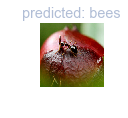

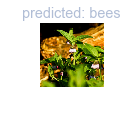

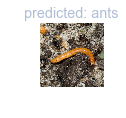

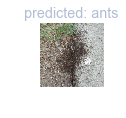

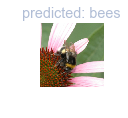

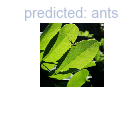

In [121]:
visualize_model(model_ft)

# Freeze parameters to use as feature extrator

In [122]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [123]:
model_ft = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6960 Acc: 0.6475
val Loss: 0.2400 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.6026 Acc: 0.7213
val Loss: 0.3338 Acc: 0.8431

Epoch 2/24
----------
train Loss: 0.4210 Acc: 0.8279
val Loss: 0.2199 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.3516 Acc: 0.8361
val Loss: 0.2094 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.5750 Acc: 0.7541
val Loss: 0.2189 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.4636 Acc: 0.7992
val Loss: 0.2124 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.5244 Acc: 0.8115
val Loss: 0.3224 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.3887 Acc: 0.8320
val Loss: 0.1929 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3862 Acc: 0.8197
val Loss: 0.2088 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.4849 Acc: 0.7828
val Loss: 0.2384 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3986 Acc: 0.8197
val Loss: 0.2633 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.3866 Acc: 0.8156
val Loss: 0.2016 Acc: 0.9346

Ep

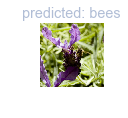

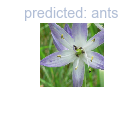

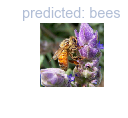

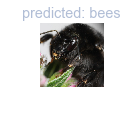

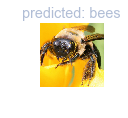

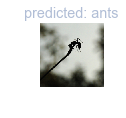

In [124]:
visualize_model(model_conv)

plt.ioff()
plt.show()